# Modeling Volitility Using GARCH

In [142]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [143]:
import yfinance as yf
import pandas as pd
import numpy as np

## Importing and Cleaning Data Using API

In [144]:
# Download Bitcoin historical data
btc = yf.download('BTC-USD', start='2020-01-01', end='2025-01-01')

# Just keep the Date and Close columns
btc = btc[['Close']]
btc.reset_index(inplace=True)

# Display first few rows
print(btc)

# Optional: Save to CSV
btc.to_csv('bitcoin_2018_2022.csv', index=False)

[*********************100%***********************]  1 of 1 completed

Price        Date         Close
Ticker                  BTC-USD
0      2020-01-01   7200.174316
1      2020-01-02   6985.470215
2      2020-01-03   7344.884277
3      2020-01-04   7410.656738
4      2020-01-05   7411.317383
...           ...           ...
1822   2024-12-27  94164.859375
1823   2024-12-28  95163.929688
1824   2024-12-29  93530.226562
1825   2024-12-30  92643.210938
1826   2024-12-31  93429.203125

[1827 rows x 2 columns]


In [145]:
# Calculate daily log returns
btc['Log_Return'] = np.log(btc['Close'] / btc['Close'].shift(1)) #Logarithmic returns give you the rate of change between two prices but adjusted for compounding.

# Drop the first row (NaN return)
btc.dropna(inplace=True)

# Flatten the MultiIndex columns correctly
btc.columns = [' '.join(col).strip() for col in btc.columns.to_flat_index()]

# Verify the column names
print(btc.columns)

# Save the returns to a CSV
btc.to_csv('bitcoin_log_returns_2018_2022.csv', index=False)

Index(['Date', 'Close BTC-USD', 'Log_Return'], dtype='object')


## Figures of Closing Prices and Returns 

In [146]:
import matplotlib.pyplot as plt

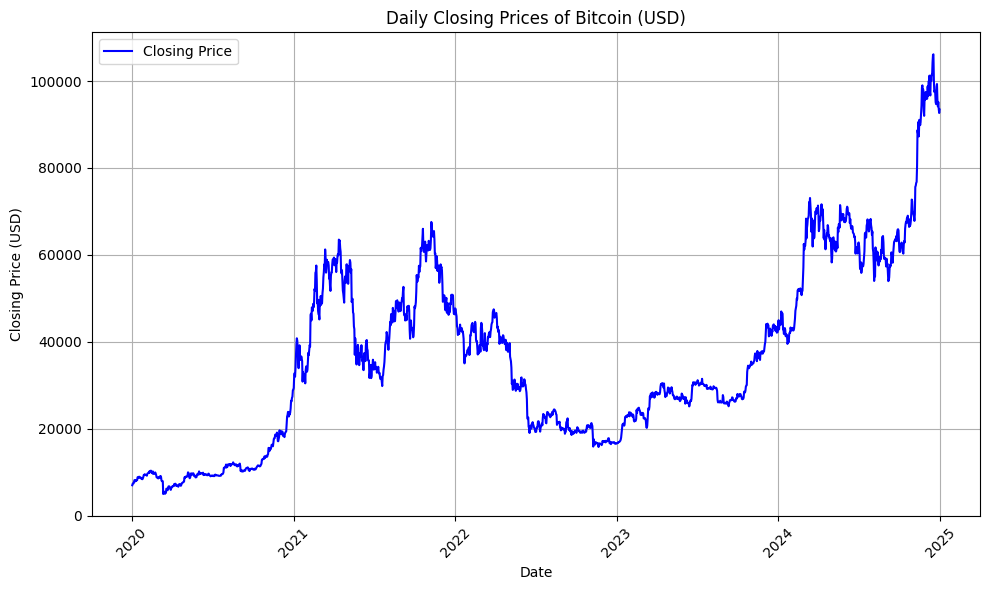

In [147]:
# Plot Daily Closing Prices
plt.figure(figsize=(10, 6))
plt.plot(btc['Date'], btc['Close BTC-USD'], label='Closing Price', color='blue')
plt.title('Daily Closing Prices of Bitcoin (USD)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

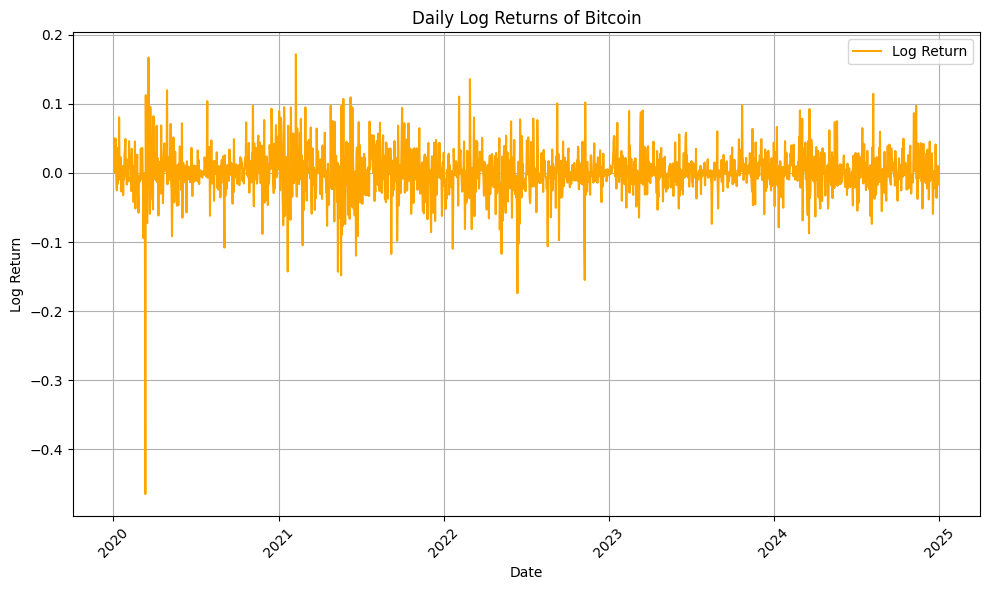

In [148]:
# Plot Daily Log Returns (if Log_Return column exists)
btc['Log_Return'] = np.log(btc['Close BTC-USD'] / btc['Close BTC-USD'].shift(1))

plt.figure(figsize=(10, 6))
plt.plot(btc['Date'], btc['Log_Return'], label='Log Return', color='orange')
plt.title('Daily Log Returns of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Summary Statistics (Test for Normality and Stationarity)

In [149]:
# Generate summary statistics for the log returns
summary_stats = btc['Log_Return'].describe()

# Display the summary statistics
print(summary_stats)

count    1825.000000
mean        0.001421
std         0.034078
min        -0.464730
25%        -0.012909
50%         0.000694
75%         0.016409
max         0.171821
Name: Log_Return, dtype: float64


In [150]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [151]:
from scipy import stats
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller, kpss

In [152]:
# Drop NaN and inf values
btc = btc.replace([np.inf, -np.inf], np.nan)  # replace inf with NaN
btc = btc.dropna(subset=['Log_Return'])        # drop rows where Log_Return is NaN

In [153]:
# 1. Kurtosis
kurtosis = btc['Log_Return'].kurtosis()

# 2. Skewness
skewness = btc['Log_Return'].skew()

# 3. Jarque-Bera Test (JB test)
jb_test_stat, jb_p_value = stats.jarque_bera(btc['Log_Return'])

# 4. ARCH Test (testing for heteroskedasticity)
arch_test_stat, arch_p_value, _, _ = het_arch(btc['Log_Return'])

# 5. Unit Root Tests:
# - Augmented Dickey-Fuller Test (ADF)
adf_stat, adf_p_value, _, _, _, _ = adfuller(btc['Log_Return'])

# - Phillips-Perron Test (PP)
pp_stat, pp_p_value, _, _ = kpss(btc['Log_Return'], regression='c')

# Creating a summary table
summary_stats = {
    'Kurtosis': kurtosis,
    'Skewness': skewness,
    'Jarque-Bera Test Statistic': jb_test_stat,
    'Jarque-Bera P-value': jb_p_value,
    'ARCH Test Statistic': arch_test_stat,
    'ARCH P-value': arch_p_value,
    'ADF Statistic': adf_stat,
    'ADF P-value': adf_p_value,
    'PP Statistic': pp_stat,
    'PP P-value': pp_p_value
}

# Displaying the results
summary_table = pd.DataFrame(summary_stats, index=[0])
print(summary_table)

    Kurtosis  Skewness  Jarque-Bera Test Statistic  Jarque-Bera P-value  \
0  21.507425  -1.40236                35568.696313                  0.0   

   ARCH Test Statistic  ARCH P-value  ADF Statistic   ADF P-value  \
0            37.971099      0.000038     -13.883388  6.152445e-26   

   PP Statistic  PP P-value  
0      0.170555         0.1  


/tmp/ipykernel_2718552/4204882327.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  pp_stat, pp_p_value, _, _ = kpss(btc['Log_Return'], regression='c')


## ACF and PACF Plots

In [154]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

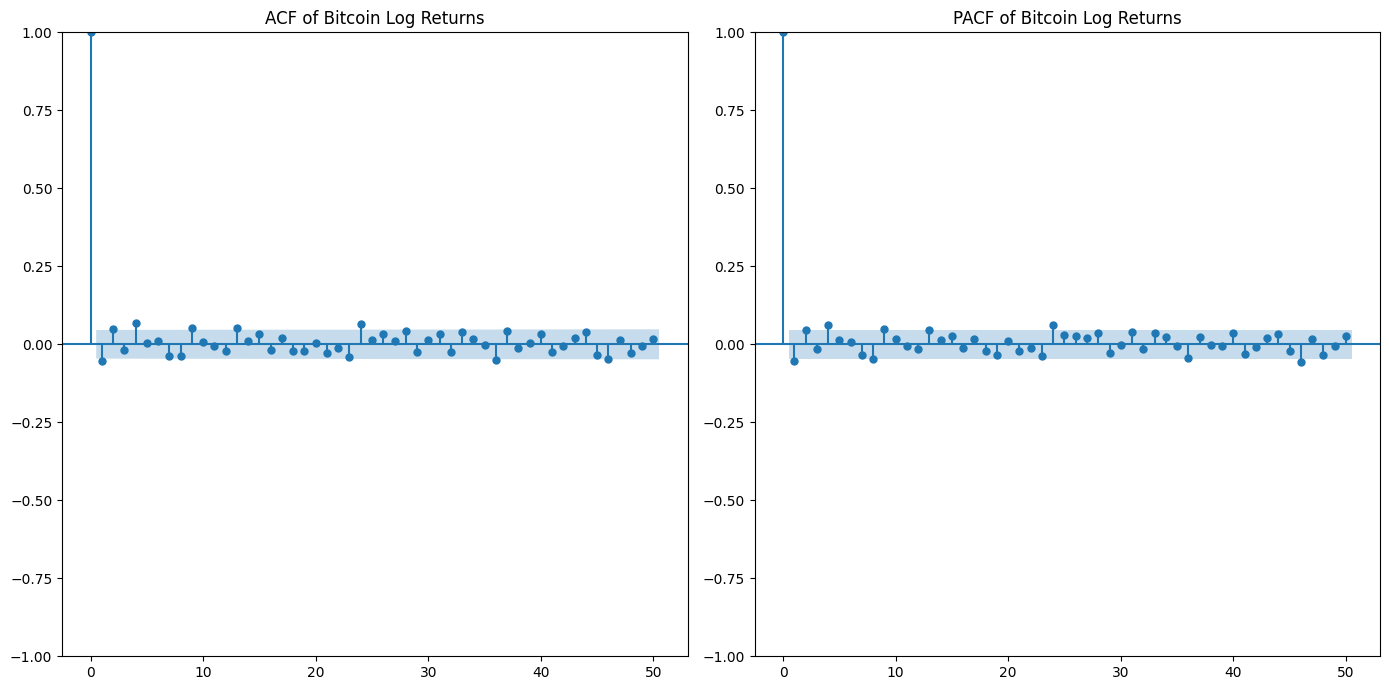

In [155]:
# Plot ACF and PACF for Log Returns
plt.figure(figsize=(14, 7))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(btc['Log_Return'], lags=50, ax=plt.gca(), title='ACF of Bitcoin Log Returns')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(btc['Log_Return'], lags=50, ax=plt.gca(), title='PACF of Bitcoin Log Returns')

plt.tight_layout()
plt.show()

## GARCH(1,1)

In [156]:
!pip install arch

Defaulting to user installation because normal site-packages is not writeable


In [157]:
import matplotlib.pyplot as plt
from arch import arch_model

Iteration:      1,   Func. Count:      6,   Neg. LLF: 762143003.3770874
Iteration:      2,   Func. Count:     18,   Neg. LLF: 340015.73398756096
Iteration:      3,   Func. Count:     25,   Neg. LLF: 544.2161807285945


/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     33,   Neg. LLF: -3401.0111488747743
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1015306811.4717494
Iteration:      6,   Func. Count:     51,   Neg. LLF: -2235.385104316999
Iteration:      7,   Func. Count:     60,   Neg. LLF: -2860.7767774247523
Iteration:      8,   Func. Count:     67,   Neg. LLF: -3656.7242936268985
Iteration:      9,   Func. Count:     73,   Neg. LLF: -3664.207107690577
Iteration:     10,   Func. Count:     79,   Neg. LLF: -3642.172621526407
Iteration:     11,   Func. Count:     86,   Neg. LLF: -3659.859521388528
Iteration:     12,   Func. Count:     92,   Neg. LLF: -3670.0241832527277
Iteration:     13,   Func. Count:     98,   Neg. LLF: -3670.1938882390373
Iteration:     14,   Func. Count:    103,   Neg. LLF: -3670.193972548892
Iteration:     15,   Func. Count:    107,   Neg. LLF: -3670.1939725492193
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3670.193972548892
         

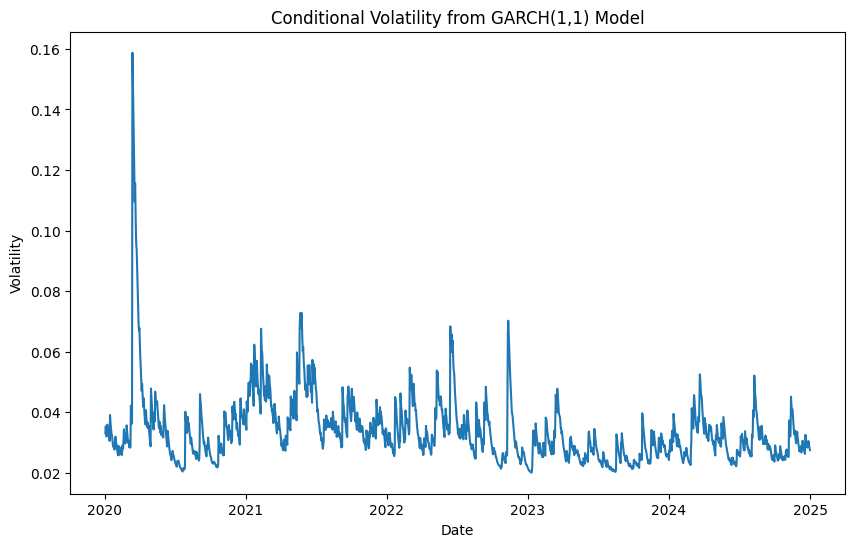

In [158]:
# Assuming `btc['Log_Return']` contains the log returns of Bitcoin

# Step 1: Create the GARCH(1,1) model
model = arch_model(btc['Log_Return'], vol='Garch', p=1, q=1)

# Step 2: Fit the model to the data
garch_fit = model.fit()

# Step 3: Print the model summary
print(garch_fit.summary())

# Step 4: Plot the Conditional Volatility (Volatility predicted by GARCH model)
plt.figure(figsize=(10, 6))
plt.plot(btc['Date'],garch_fit.conditional_volatility)
plt.title('Conditional Volatility from GARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [159]:
# Step 5: Extract and print the AIC for the fitted GARCH model

# Total number of observations used in the fit
T = garch_fit.nobs

# Raw AIC/BIC
aic_raw = garch_fit.aic
bic_raw = garch_fit.bic

# Per-observation (average) AIC/BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for GARCH(1,1):        {aic_raw:.2f}')
print(f'Average AIC per observation:   {aic_per_obs:.4f}')
print(f'Raw BIC for GARCH(1,1):        {bic_raw:.2f}')
print(f'Average BIC per observation:   {bic_per_obs:.4f}')


Raw AIC for GARCH(1,1):        -7332.39
Average AIC per observation:   -4.0177
Raw BIC for GARCH(1,1):        -7310.35
Average BIC per observation:   -4.0057


### AR(1)-GARCH(1,1)

In [160]:
from arch import arch_model
import matplotlib.pyplot as plt

Iteration:      1,   Func. Count:      7,   Neg. LLF: 646528580.931637
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1973272.8241240464
Iteration:      3,   Func. Count:     29,   Neg. LLF: 1404.3061041745457
Iteration:      4,   Func. Count:     37,   Neg. LLF: 143922.94239971437
Iteration:      5,   Func. Count:     47,   Neg. LLF: 1949410292.3066008
Iteration:      6,   Func. Count:     60,   Neg. LLF: 2404.4789538018335
Iteration:      7,   Func. Count:     69,   Neg. LLF: 1860.7682642738669
Iteration:      8,   Func. Count:     79,   Neg. LLF: 7265.840121756293
Iteration:      9,   Func. Count:     90,   Neg. LLF: -3498.4585792662274
Iteration:     10,   Func. Count:     97,   Neg. LLF: -3605.199851140834
Iteration:     11,   Func. Count:    104,   Neg. LLF: -1046.823096162246
Iteration:     12,   Func. Count:    112,   Neg. LLF: -3656.0787191626314
Iteration:     13,   Func. Count:    119,   Neg. LLF: -3541.956728983173
Iteration:     14,   Func. Count:    126,   Neg. LLF

/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


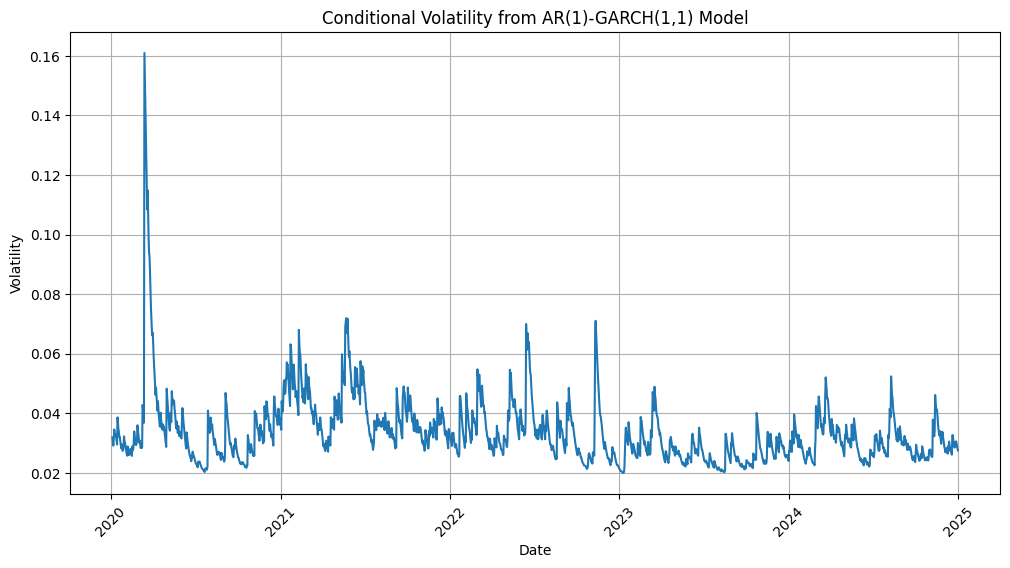

In [161]:
# Step 1: Create the AR(1)-GARCH(1,1) model
model = arch_model(
    btc['Log_Return'],
    mean='AR',     # AR term in the mean
    lags=1,        # AR(1)
    vol='Garch',   # GARCH volatility model
    p=1, q=1
)

# Step 2: Fit the model
garch_fit = model.fit()

# Step 3: Print the model summary
print(garch_fit.summary())

# Step 4: Plot the Conditional Volatility
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], garch_fit.conditional_volatility)
plt.title('Conditional Volatility from AR(1)-GARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [162]:
# Step 5: Extract and print the AIC for the AR(1)-GARCH(1,1) model
# Assuming garch_fit is your fitted AR(1)-GARCH(1,1) result:

# Total number of observations used in the AR(1)-GARCH(1,1) fit
T = garch_fit.nobs

# Raw AIC/BIC
aic_raw = garch_fit.aic
bic_raw = garch_fit.bic

# Per-observation (average) AIC/BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for AR(1)-GARCH(1,1):        {aic_raw:.2f}')
print(f'Average AIC per observation:         {aic_per_obs:.4f}')
print(f'Raw BIC for AR(1)-GARCH(1,1):        {bic_raw:.2f}')
print(f'Average BIC per observation:         {bic_per_obs:.4f}')


Raw AIC for AR(1)-GARCH(1,1):        -7330.40
Average AIC per observation:         -4.0189
Raw BIC for AR(1)-GARCH(1,1):        -7302.85
Average BIC per observation:         -4.0038


In [163]:
#The plot shows the estimated volatility at each point in time, based on your past log returns. 
#It gives you a sense of how volatile Bitcoin's price was at any given point in time during the 
#period under consideration, allowing you to better understand the risk level at any point in the past.


## EGARCH(1,1)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.3807848710911647e+18
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7867.854164789024
Iteration:      3,   Func. Count:     30,   Neg. LLF: 280187031940.58276
Iteration:      4,   Func. Count:     39,   Neg. LLF: 1554381412.4188018
Iteration:      5,   Func. Count:     48,   Neg. LLF: -3634.7643362346303
Iteration:      6,   Func. Count:     55,   Neg. LLF: 2128537.6450280766
Iteration:      7,   Func. Count:     62,   Neg. LLF: -3628.8359315373054
Iteration:      8,   Func. Count:     69,   Neg. LLF: -3683.9433750102426
Iteration:      9,   Func. Count:     75,   Neg. LLF: -3684.4174552659806
Iteration:     10,   Func. Count:     81,   Neg. LLF: -3684.4758699582867
Iteration:     11,   Func. Count:     87,   Neg. LLF: -3684.478759579788
Iteration:     12,   Func. Count:     93,   Neg. LLF: -3684.4802817436425
Iteration:     13,   Func. Count:     99,   Neg. LLF: -3684.4802984937432
Iteration:     14,   Func. Count:    106,

/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


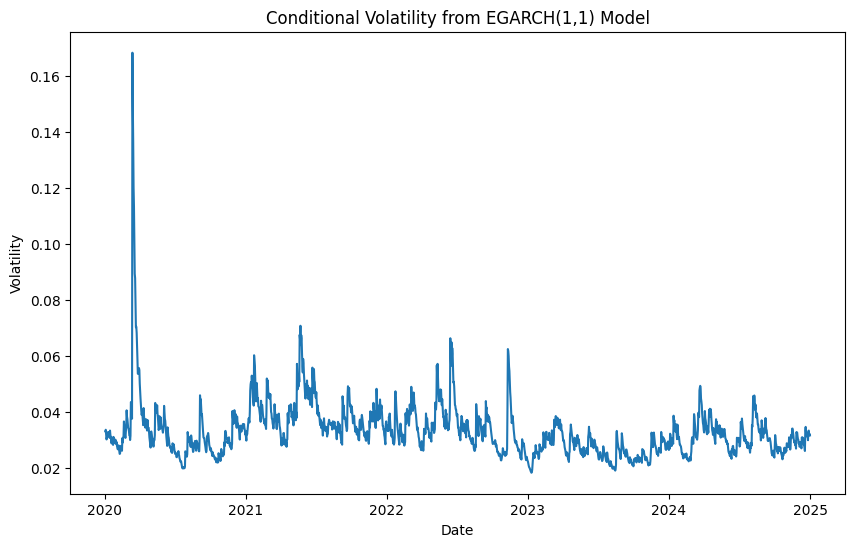

In [164]:
# Assuming btc['Log_Return'] contains the log returns of Bitcoin

# Step 1: Create the EGARCH(1,1) model
model = arch_model(btc['Log_Return'], vol='EGARCH', p=1, o=1, q=1)

# Step 2: Fit the model to the data
egarch_fit = model.fit()

# Step 3: Print the model summary
print(egarch_fit.summary())

# Step 4: Plot the Conditional Volatility (Volatility predicted by EGARCH model)
plt.figure(figsize=(10, 6))
plt.plot(btc['Date'],egarch_fit.conditional_volatility)
plt.title('Conditional Volatility from EGARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [165]:
# Step 5: Extract and print raw and per-observation AIC & BIC for the fitted EGARCH model

# Total number of observations used in the EGARCH fit
T = egarch_fit.nobs

# Raw AIC/BIC
aic_raw = egarch_fit.aic
bic_raw = egarch_fit.bic

# Per-observation (average) AIC/BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for EGARCH(1,1):           {aic_raw:.2f}')
print(f'Average AIC per observation:       {aic_per_obs:.4f}')
print(f'Raw BIC for EGARCH(1,1):           {bic_raw:.2f}')
print(f'Average BIC per observation:       {bic_per_obs:.4f}')


Raw AIC for EGARCH(1,1):           -7358.96
Average AIC per observation:       -4.0323
Raw BIC for EGARCH(1,1):           -7331.41
Average BIC per observation:       -4.0172


### AR(1)-EGARCH(1,1)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1.6664017900694518e+18
Iteration:      2,   Func. Count:     22,   Neg. LLF: 24552794831.98821
Iteration:      3,   Func. Count:     33,   Neg. LLF: 210241528110.52258
Iteration:      4,   Func. Count:     43,   Neg. LLF: 20869888542.052746
Iteration:      5,   Func. Count:     54,   Neg. LLF: 4268.471208631629
Iteration:      6,   Func. Count:     64,   Neg. LLF: -3635.897467150638
Iteration:      7,   Func. Count:     72,   Neg. LLF: -3641.4545110411627
Iteration:      8,   Func. Count:     80,   Neg. LLF: -3631.5367620471675
Iteration:      9,   Func. Count:     88,   Neg. LLF: -3684.6797524376775
Iteration:     10,   Func. Count:     96,   Neg. LLF: -3685.4563240442117
Iteration:     11,   Func. Count:    103,   Neg. LLF: -3685.4718462864644
Iteration:     12,   Func. Count:    110,   Neg. LLF: -3685.4725915879217
Iteration:     13,   Func. Count:    117,   Neg. LLF: -3685.4726699225675
Iteration:     14,   Func. Count:    124, 

/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


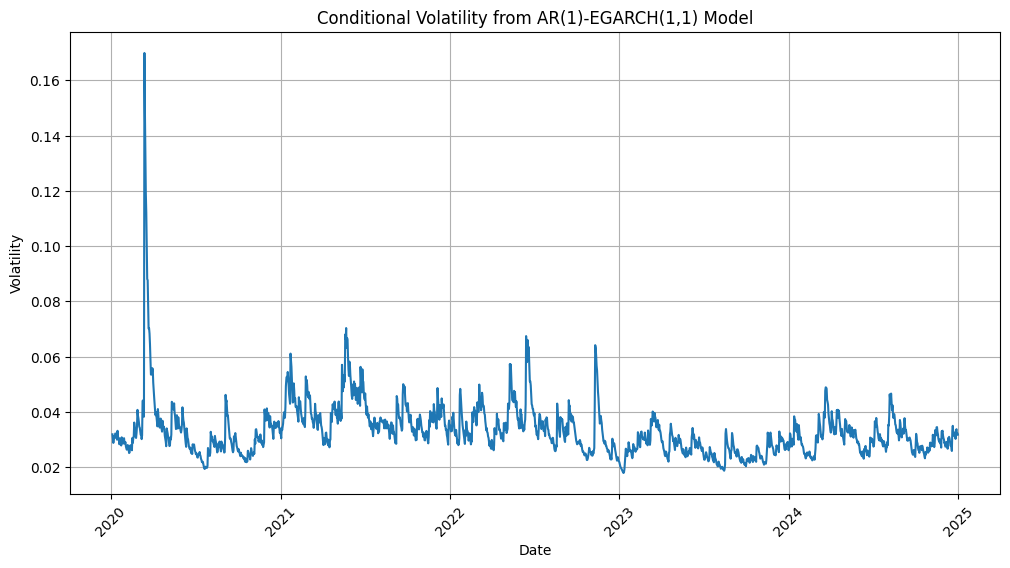

In [166]:
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Create the AR(1)-EGARCH(1,1) model
model = arch_model(
    btc['Log_Return'],
    mean='AR',     # AR term in the mean
    lags=1,        # AR(1)
    vol='EGARCH',  # EGARCH volatility model
    p=1, o=1, q=1
)

# Step 2: Fit the model
egarch_fit = model.fit()

# Step 3: Print the model summary
print(egarch_fit.summary())

# Step 4: Plot the Conditional Volatility
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], egarch_fit.conditional_volatility)
plt.title('Conditional Volatility from AR(1)-EGARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.xticks(rotation=45)
plt.show()


In [167]:
# Step 5: Extract and print raw and per-observation AIC & BIC for the AR(1)-EGARCH(1,1) model

# Total number of observations used in the AR(1)-EGARCH fit
T = egarch_fit.nobs

# Raw AIC/BIC
aic_raw = egarch_fit.aic
bic_raw = egarch_fit.bic

# Per-observation (average) AIC/BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for AR(1)-EGARCH(1,1):          {aic_raw:.2f}')
print(f'Average AIC per observation:            {aic_per_obs:.4f}')
print(f'Raw BIC for AR(1)-EGARCH(1,1):          {bic_raw:.2f}')
print(f'Average BIC per observation:            {bic_per_obs:.4f}')


Raw AIC for AR(1)-EGARCH(1,1):          -7358.95
Average AIC per observation:            -4.0345
Raw BIC for AR(1)-EGARCH(1,1):          -7325.89
Average BIC per observation:            -4.0164


## TGARCH(1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2247.290627572073
Iteration:      2,   Func. Count:     15,   Neg. LLF: -3145.1182944626607
Iteration:      3,   Func. Count:     22,   Neg. LLF: -3375.5635231365113
Iteration:      4,   Func. Count:     29,   Neg. LLF: -3454.7690443494885
Iteration:      5,   Func. Count:     35,   Neg. LLF: -3579.450287478798
Iteration:      6,   Func. Count:     41,   Neg. LLF: -3672.1157676472235
Iteration:      7,   Func. Count:     47,   Neg. LLF: -2618.88948548931
Iteration:      8,   Func. Count:     53,   Neg. LLF: -3674.881040695394
Iteration:      9,   Func. Count:     59,   Neg. LLF: -3681.7271672518145
Iteration:     10,   Func. Count:     65,   Neg. LLF: -3681.836366738668
Iteration:     11,   Func. Count:     71,   Neg. LLF: -3681.8461560214946
Iteration:     12,   Func. Count:     76,   Neg. LLF: -3681.8461769922524
Iteration:     13,   Func. Count:     80,   Neg. LLF: -3681.846176991573
Optimization terminated successfully    (Exit

/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


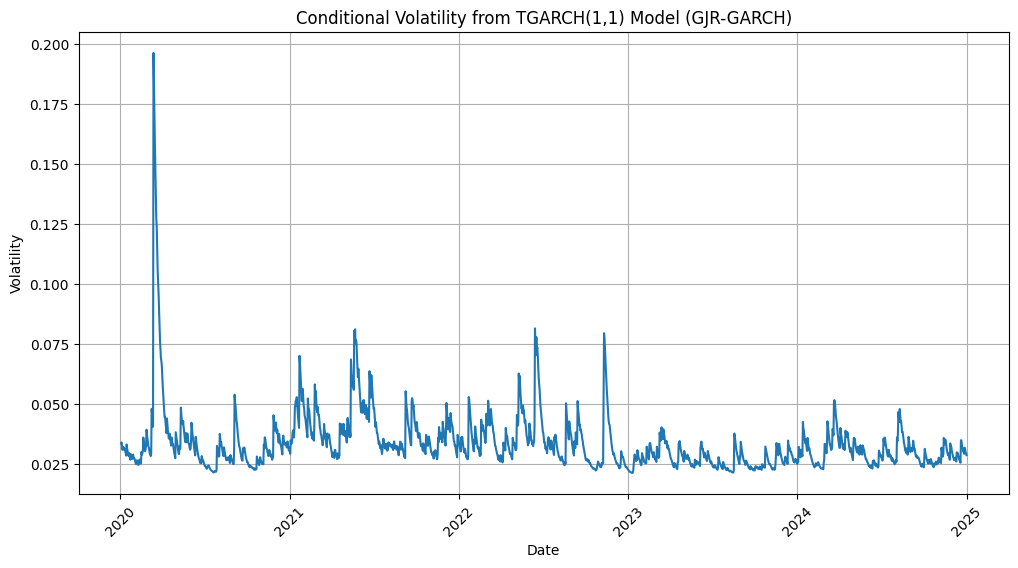

In [168]:
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Create the TGARCH(1,1) model
model = arch_model(
    btc['Log_Return'],
    mean='Zero',     # Mean model (you can also set mean='AR' if you want AR terms)
    vol='GARCH',     # Still GARCH, but asymmetry is introduced
    p=1, o=1, q=1    # o=1 adds the asymmetry term (GJR/TGARCH)
)

# Step 2: Fit the model
tgarch_fit = model.fit()

# Step 3: Print the model summary
print(tgarch_fit.summary())

# Step 4: Plot the Conditional Volatility
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], tgarch_fit.conditional_volatility)
plt.title('Conditional Volatility from TGARCH(1,1) Model (GJR-GARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [169]:
# Step 5: Extract and print raw and per-observation AIC & BIC for the TGARCH(1,1) model

# Total number of observations used in the TGARCH fit
T = tgarch_fit.nobs

# Raw AIC/BIC
aic_raw = tgarch_fit.aic
bic_raw = tgarch_fit.bic

# Per-observation (average) AIC/BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for TGARCH(1,1):               {aic_raw:.2f}')
print(f'Average AIC per observation:           {aic_per_obs:.4f}')
print(f'Raw BIC for TGARCH(1,1):               {bic_raw:.2f}')
print(f'Average BIC per observation:           {bic_per_obs:.4f}')


Raw AIC for TGARCH(1,1):               -7355.69
Average AIC per observation:           -4.0305
Raw BIC for TGARCH(1,1):               -7333.66
Average BIC per observation:           -4.0184


### AR(1)-TGARCH(1,1)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 218768280.5305682
Iteration:      2,   Func. Count:     22,   Neg. LLF: 70133.63452515024
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1250910031531.3572
Iteration:      4,   Func. Count:     44,   Neg. LLF: 326604810.01900387
Iteration:      5,   Func. Count:     53,   Neg. LLF: -3174.5181885523484
Iteration:      6,   Func. Count:     63,   Neg. LLF: 13924265.314163584
Iteration:      7,   Func. Count:     73,   Neg. LLF: -2336.652186265447
Iteration:      8,   Func. Count:     83,   Neg. LLF: -3612.8310160529427
Iteration:      9,   Func. Count:     91,   Neg. LLF: -3592.449033007034
Iteration:     10,   Func. Count:     99,   Neg. LLF: -3674.522119422765
Iteration:     11,   Func. Count:    107,   Neg. LLF: -3549.449930396823
Iteration:     12,   Func. Count:    115,   Neg. LLF: -3683.0871599425336
Iteration:     13,   Func. Count:    123,   Neg. LLF: -3683.1022670482807
Iteration:     14,   Func. Count:    131,   Neg. 

/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


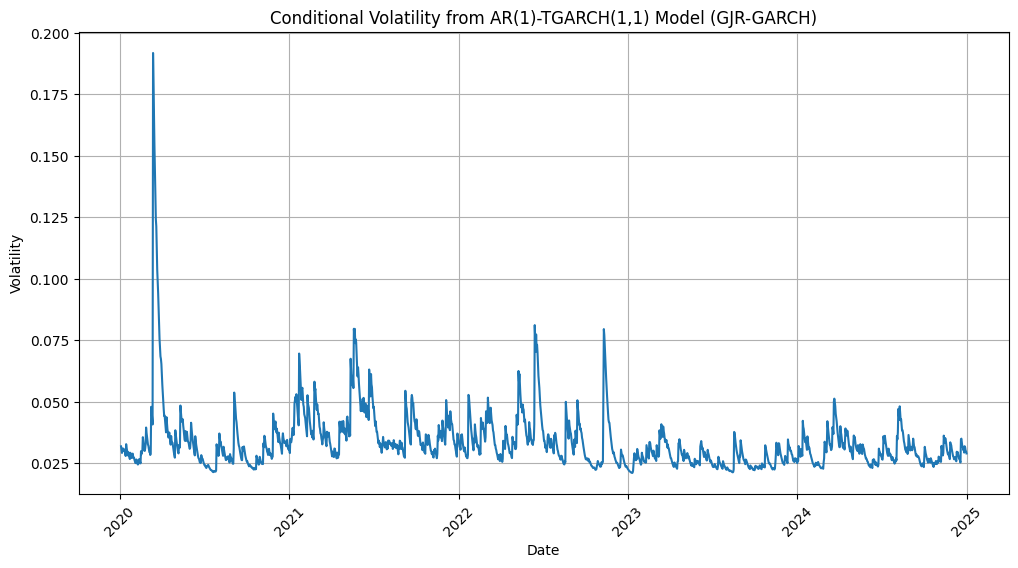

In [170]:
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Create the AR(1)-TGARCH(1,1) model
model = arch_model(
    btc['Log_Return'],
    mean='AR',     # AR(1) term in the mean
    lags=1,        # Lag = 1
    vol='GARCH',   # GARCH type model
    p=1, o=1, q=1  # o=1 introduces asymmetry (this makes it TGARCH or GJR-GARCH)
)

# Step 2: Fit the model
tgarch_fit = model.fit()

# Step 3: Print the model summary
print(tgarch_fit.summary())

# Step 4: Plot the Conditional Volatility
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], tgarch_fit.conditional_volatility)
plt.title('Conditional Volatility from AR(1)-TGARCH(1,1) Model (GJR-GARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.xticks(rotation=45)
plt.show()


In [171]:
# Step 5: Extract and print the AIC for the AR(1)-TGARCH(1,1) model
aic_value_ar_tgarch = tgarch_fit.aic
print(f'AIC for AR(1)-TGARCH(1,1) model: {aic_value_ar_tgarch}')

AIC for AR(1)-TGARCH(1,1) model: -7354.756272717804


## APARCH(1,1)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 11769091.364289165
Iteration:      2,   Func. Count:     23,   Neg. LLF: 23366.07437891206
Iteration:      3,   Func. Count:     36,   Neg. LLF: 1317085068.9755306
Iteration:      4,   Func. Count:     45,   Neg. LLF: 455311865.9224775
Iteration:      5,   Func. Count:     54,   Neg. LLF: -2111.4345957872947
Iteration:      6,   Func. Count:     62,   Neg. LLF: -3501.695579758828
Iteration:      7,   Func. Count:     71,   Neg. LLF: -3648.8366398589123
Iteration:      8,   Func. Count:     79,   Neg. LLF: -3678.295960032311
Iteration:      9,   Func. Count:     87,   Neg. LLF: -3679.761099652272


/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:     95,   Neg. LLF: -3685.3125028904624
Iteration:     11,   Func. Count:    102,   Neg. LLF: -3685.336977340765
Iteration:     12,   Func. Count:    109,   Neg. LLF: -3685.3631699935404
Iteration:     13,   Func. Count:    116,   Neg. LLF: -3685.407229882333
Iteration:     14,   Func. Count:    123,   Neg. LLF: -3685.476105153143
Iteration:     15,   Func. Count:    130,   Neg. LLF: -3685.543471876401
Iteration:     16,   Func. Count:    137,   Neg. LLF: -3685.577710897344
Iteration:     17,   Func. Count:    144,   Neg. LLF: -3685.5566166149697
Iteration:     18,   Func. Count:    152,   Neg. LLF: -3685.634776337658
Iteration:     19,   Func. Count:    159,   Neg. LLF: -3685.650957352551
Iteration:     20,   Func. Count:    166,   Neg. LLF: -3685.6693573267685
Iteration:     21,   Func. Count:    173,   Neg. LLF: -3685.6876317299134
Iteration:     22,   Func. Count:    180,   Neg. LLF: -3685.696485117701
Iteration:     23,   Func. Count:    187,   Ne

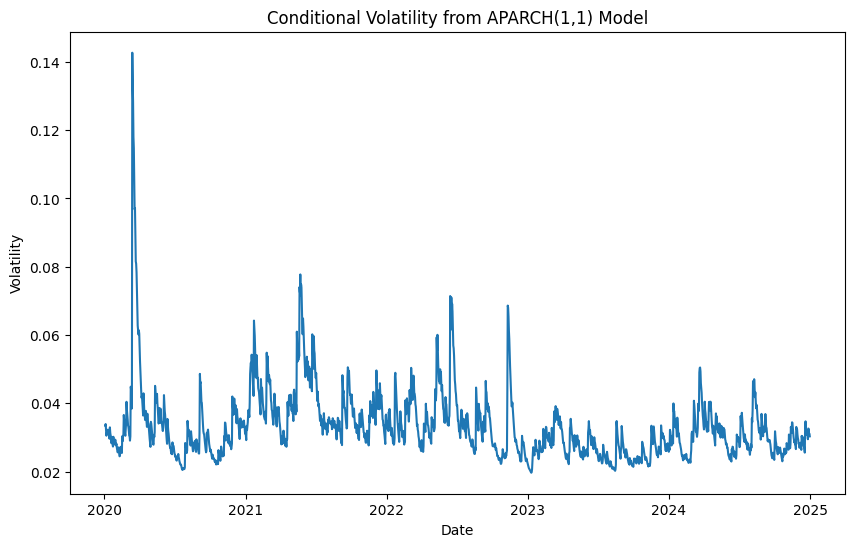

In [172]:
# Assuming btc['Log_Return'] contains the log returns of Bitcoin

# Step 1: Create the APARCH(1,1) model
# 'power' allows you to specify the power transformation for the volatility
model = arch_model(btc['Log_Return'], vol='APARCH', p=1, q=1, power=2.0, o=1)

# Step 2: Fit the model to the data
aparch_fit = model.fit()

# Step 3: Print the model summary
print(aparch_fit.summary())

# Step 4: Plot the Conditional Volatility (Volatility predicted by APARCH model)
plt.figure(figsize=(10, 6))
plt.plot(btc['Date'],aparch_fit.conditional_volatility)
plt.title('Conditional Volatility from APARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [173]:
# Step 5: Extract and print raw and per-observation AIC & BIC for the APARCH(1,1) model

# Total number of observations used in the APARCH fit
T = aparch_fit.nobs

# Raw AIC/BIC
aic_raw = aparch_fit.aic
bic_raw = aparch_fit.bic

# Per-observation (average) AIC/BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for APARCH(1,1):               {aic_raw:.2f}')
print(f'Average AIC per observation:           {aic_per_obs:.4f}')
print(f'Raw BIC for APARCH(1,1):               {bic_raw:.2f}')
print(f'Average BIC per observation:           {bic_per_obs:.4f}')


Raw AIC for APARCH(1,1):               -7359.45
Average AIC per observation:           -4.0326
Raw BIC for APARCH(1,1):               -7326.39
Average BIC per observation:           -4.0145


### AR(1)-APARCH(1,1)

Iteration:      1,   Func. Count:      9,   Neg. LLF: 2848250855408.928
Iteration:      2,   Func. Count:     24,   Neg. LLF: 20349.17442609596
Iteration:      3,   Func. Count:     40,   Neg. LLF: 3917207.3698960296
Iteration:      4,   Func. Count:     55,   Neg. LLF: 22711200311648.953
Iteration:      5,   Func. Count:     67,   Neg. LLF: 1963010757.7944164
Iteration:      6,   Func. Count:     77,   Neg. LLF: 660422154.1298496
Iteration:      7,   Func. Count:     87,   Neg. LLF: -2497.5310314495728


/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     96,   Neg. LLF: -3665.762631283181
Iteration:      9,   Func. Count:    105,   Neg. LLF: -3676.8367740440654
Iteration:     10,   Func. Count:    114,   Neg. LLF: -3684.7634269073687
Iteration:     11,   Func. Count:    122,   Neg. LLF: -3684.8323097694856
Iteration:     12,   Func. Count:    130,   Neg. LLF: -3684.199898399218
Iteration:     13,   Func. Count:    139,   Neg. LLF: -3685.0124410991466
Iteration:     14,   Func. Count:    147,   Neg. LLF: -3685.0694204677197
Iteration:     15,   Func. Count:    155,   Neg. LLF: -3685.153707031719
Iteration:     16,   Func. Count:    163,   Neg. LLF: -3685.248010170386
Iteration:     17,   Func. Count:    171,   Neg. LLF: -3685.444992509919
Iteration:     18,   Func. Count:    179,   Neg. LLF: -3685.4067217971788
Iteration:     19,   Func. Count:    188,   Neg. LLF: -3685.6340521387774
Iteration:     20,   Func. Count:    196,   Neg. LLF: -3685.7459777336776
Iteration:     21,   Func. Count:    204,  

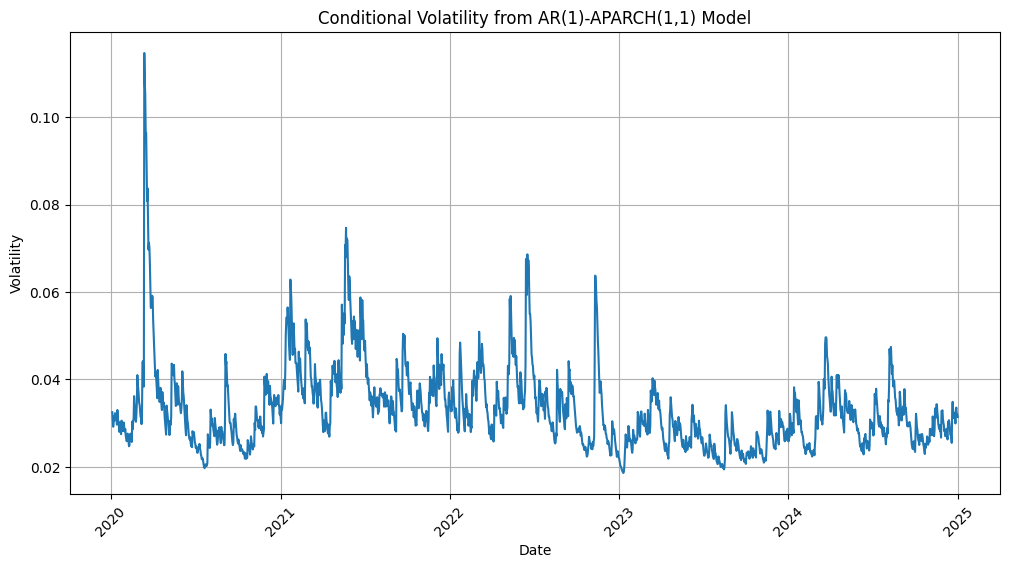

In [174]:
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Create the AR(1)-APARCH(1,1) model
model = arch_model(
    btc['Log_Return'],
    mean='AR',      # AR term in the mean
    lags=1,         # AR(1)
    vol='APARCH',   # APARCH volatility model
    p=1, o=1, q=1,  # p=1, o=1, q=1 for asymmetry
    power=2.0       # Standard is 2 (variance), but APARCH allows it to vary
)

# Step 2: Fit the model
aparch_fit = model.fit()

# Step 3: Print the model summary
print(aparch_fit.summary())

# Step 4: Plot the Conditional Volatility
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], aparch_fit.conditional_volatility)
plt.title('Conditional Volatility from AR(1)-APARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.xticks(rotation=45)
plt.show()


In [175]:
# Step 5: Extract and print raw and per‐observation AIC & BIC for the AR(1)‐APARCH(1,1) model

# Total number of observations used in the AR(1)-APARCH(1,1) fit
T = aparch_fit.nobs

# Raw AIC & BIC
aic_raw = aparch_fit.aic
bic_raw = aparch_fit.bic

# Per‐observation (average) AIC & BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for AR(1)-APARCH(1,1):             {aic_raw:.2f}')
print(f'Average AIC per observation:               {aic_per_obs:.4f}')
print(f'Raw BIC for AR(1)-APARCH(1,1):             {bic_raw:.2f}')
print(f'Average BIC per observation:               {bic_per_obs:.4f}')


Raw AIC for AR(1)-APARCH(1,1):             -7358.56
Average AIC per observation:               -4.0343
Raw BIC for AR(1)-APARCH(1,1):             -7319.99
Average BIC per observation:               -4.0132


## Component-GARCH(1,1)

In [176]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Estimated Parameters:
omega=0.01000, alpha=0.05000, beta=0.90000, rho=0.90000, phi=0.05000


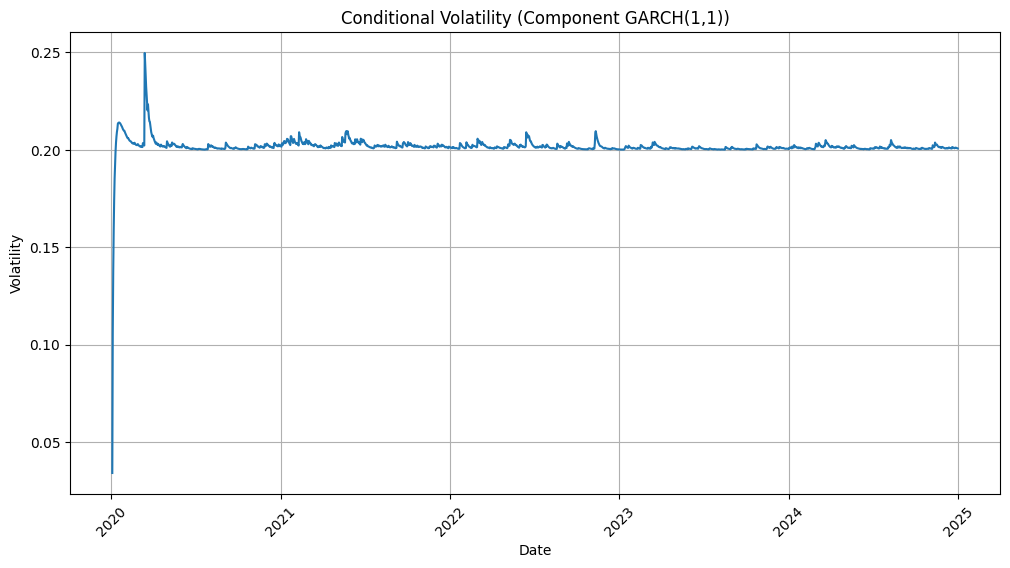

In [177]:
# Assume btc['Log_Return'] already exists
returns = btc['Log_Return'].dropna().values

# Step 1: Define CGARCH(1,1) log-likelihood
def cgarch_likelihood(params, returns):
    omega, alpha, beta, rho, phi = params

    T = len(returns)
    h = np.zeros(T)
    q = np.zeros(T)

    # Initialize starting values
    var_init = np.var(returns)
    h[0] = var_init
    q[0] = var_init

    for t in range(1, T):
        q[t] = omega + rho * q[t-1] + phi * (returns[t-1]**2 - h[t-1])
        h[t] = q[t] + alpha * (returns[t-1]**2 - q[t-1]) + beta * (h[t-1] - q[t-1])

    # Ensure positive variance
    h = np.maximum(h, 1e-8)

    # Compute log-likelihood (assuming normal errors)
    loglik = -0.5 * (np.log(2 * np.pi) + np.log(h) + (returns**2) / h)
    return -np.sum(loglik)

# Step 2: Set Initial Parameters and Bounds
initial_params = [0.01, 0.05, 0.9, 0.9, 0.05]
bounds = [(1e-6, None),  # omega > 0
          (0, 1),        # 0 <= alpha <= 1
          (0, 1),        # 0 <= beta <= 1
          (0, 1),        # 0 <= rho <= 1
          (-1, 1)]       # -1 <= phi <= 1

# Step 3: Minimize negative log-likelihood
result = minimize(cgarch_likelihood, initial_params, args=(returns,),
                  bounds=bounds, method='L-BFGS-B')

# Step 4: Get fitted parameters
omega, alpha, beta, rho, phi = result.x
print(f"Estimated Parameters:\nomega={omega:.5f}, alpha={alpha:.5f}, beta={beta:.5f}, rho={rho:.5f}, phi={phi:.5f}")

# Step 5: Recompute h_t and plot
T = len(returns)
h = np.zeros(T)
q = np.zeros(T)
h[0] = np.var(returns)
q[0] = np.var(returns)

for t in range(1, T):
    q[t] = omega + rho * q[t-1] + phi * (returns[t-1]**2 - h[t-1])
    h[t] = q[t] + alpha * (returns[t-1]**2 - q[t-1]) + beta * (h[t-1] - q[t-1])

# Step 6: Plot Conditional Volatility
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], np.sqrt(h))  # Use the 'Date' column
plt.title('Conditional Volatility (Component GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [178]:
# After your minimize() call for CGARCH:

# Step 7: Compute raw and per-observation AIC & BIC manually for the CGARCH(1,1) model

import numpy as np

# Total number of observations used in the CGARCH fit
T = len(returns)

# Number of estimated parameters (omega, alpha, beta, rho, phi)
k = len(result.x)

# Log‐likelihood (negative of the minimized objective)
loglik = -result.fun

# Raw AIC & BIC
aic_raw = -2 * loglik + 2 * k
bic_raw = -2 * loglik + k * np.log(T)

# Per‐observation (average) AIC & BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for CGARCH(1,1):                {aic_raw:.2f}')
print(f'Average AIC per observation:            {aic_per_obs:.4f}')
print(f'Raw BIC for CGARCH(1,1):                {bic_raw:.2f}')
print(f'Average BIC per observation:            {bic_per_obs:.4f}')


Raw AIC for CGARCH(1,1):                -5596.25
Average AIC per observation:            -3.0664
Raw BIC for CGARCH(1,1):                -5568.70
Average BIC per observation:            -3.0513


### AR(1)-CGARCH(1,1)

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [180]:
# Assume btc['Log_Return'] already exists
returns = btc['Log_Return'].dropna().values

# Step 1: Define AR(1)-CGARCH(1,1) log-likelihood
def arcgarch_likelihood(params, returns):
    mu, phi_ar, omega, alpha, beta, rho, phi = params

    T = len(returns)
    h = np.zeros(T)
    q = np.zeros(T)

    # Initialize starting values
    var_init = np.var(returns)
    h[0] = var_init
    q[0] = var_init

    # Innovation terms (epsilon_t)
    eps = np.zeros(T)
    eps[0] = returns[0] - mu  # for the first one, AR(1) term is ignored

    for t in range(1, T):
        eps[t] = returns[t] - mu - phi_ar * returns[t-1]
        q[t] = omega + rho * q[t-1] + phi * (eps[t-1]**2 - h[t-1])
        h[t] = q[t] + alpha * (eps[t-1]**2 - q[t-1]) + beta * (h[t-1] - q[t-1])

    # Ensure positive variance
    h = np.maximum(h, 1e-8)

    # Compute log-likelihood
    loglik = -0.5 * (np.log(2 * np.pi) + np.log(h) + (eps**2) / h)
    return -np.sum(loglik)

# Step 2: Set Initial Parameters and Bounds
initial_params = [0.0, 0.1, 0.01, 0.05, 0.9, 0.9, 0.05]  # [mu, phi_ar, omega, alpha, beta, rho, phi]
bounds = [(-np.inf, np.inf),   # mu can be any real number
          (-1, 1),             # -1 <= phi_ar <= 1 for stationarity
          (1e-6, None),        # omega > 0
          (0, 1),              # 0 <= alpha <= 1
          (0, 1),              # 0 <= beta <= 1
          (0, 1),              # 0 <= rho <= 1
          (-1, 1)]             # -1 <= phi <= 1

# Step 3: Minimize negative log-likelihood
arcgarch_res = minimize(arcgarch_likelihood,
                        initial_params_arcgarch,
                        args=(returns,),
                        bounds=bounds_arcgarch,
                        method='L-BFGS-B')

# Step 4: Get fitted parameters
mu, phi_ar, omega, alpha, beta, rho, phi = result.x
print(f"Estimated Parameters:\nmu={mu:.5f}, phi_ar={phi_ar:.5f}, omega={omega:.5f}, alpha={alpha:.5f}, beta={beta:.5f}, rho={rho:.5f}, phi={phi:.5f}")

# Step 5: Recompute h_t
T = len(returns)
h = np.zeros(T)
q = np.zeros(T)
eps = np.zeros(T)

h[0] = np.var(returns)
q[0] = np.var(returns)
eps[0] = returns[0] - mu

for t in range(1, T):
    eps[t] = returns[t] - mu - phi_ar * returns[t-1]
    q[t] = omega + rho * q[t-1] + phi * (eps[t-1]**2 - h[t-1])
    h[t] = q[t] + alpha * (eps[t-1]**2 - q[t-1]) + beta * (h[t-1] - q[t-1])

# Step 6: Plot Conditional Volatility
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], np.sqrt(h))  # Conditional standard deviation
plt.title('Conditional Volatility (AR(1)-Component GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.xticks(rotation=45)
plt.show()

NameError: name 'initial_params_arcgarch' is not defined

In [ ]:
# Step 7: Compute and print raw and per-observation AIC & BIC for the AR(1)-CGARCH(1,1) model

import numpy as np

# Total number of observations used in the AR(1)-CGARCH fit
T = len(returns)

# Number of estimated parameters (mu, phi_ar, omega, alpha, beta, rho, phi)
k = len(result.x)

# Recover the maximized log-likelihood (negative of result.fun)
loglik = -result.fun

# Raw AIC & BIC
aic_raw = -2 * loglik + 2 * k
bic_raw = -2 * loglik + k * np.log(T)

# Per-observation (average) AIC & BIC
aic_per_obs = aic_raw / T
bic_per_obs = bic_raw / T

print(f'Raw AIC for AR(1)-CGARCH(1,1):           {aic_raw:.2f}')
print(f'Average AIC per observation:             {aic_per_obs:.4f}')
print(f'Raw BIC for AR(1)-CGARCH(1,1):           {bic_raw:.2f}')
print(f'Average BIC per observation:             {bic_per_obs:.4f}')


## ACGARCH(1,1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assume btc['Log_Return'] already exists
returns = btc['Log_Return'].dropna().values

# Step 1: Define the ACGARCH(1,1) Log-Likelihood function
def acgarch_likelihood(params, returns):
    omega, alpha, beta, rho, phi, gamma = params

    T = len(returns)
    h = np.zeros(T)
    q = np.zeros(T)

    # Initial variance estimate
    var_init = np.var(returns)
    h[0] = var_init
    q[0] = var_init

    for t in range(1, T):
        indicator = 1 if returns[t-1] < 0 else 0  # asymmetry: negative shock
        q[t] = omega + rho * q[t-1] + phi * (returns[t-1]**2 - h[t-1])
        h[t] = (q[t] + alpha * (returns[t-1]**2 - q[t-1]) 
                + beta * (h[t-1] - q[t-1]) 
                + gamma * indicator * returns[t-1]**2)

    # Ensure positive variance
    h = np.maximum(h, 1e-8)

    # Compute log-likelihood assuming normal distribution
    loglik = -0.5 * (np.log(2 * np.pi) + np.log(h) + (returns**2) / h)
    return -np.sum(loglik)

# Step 2: Set Initial Parameters and Bounds
initial_params = [0.01, 0.05, 0.9, 0.9, 0.05, 0.05]  # omega, alpha, beta, rho, phi, gamma
bounds = [(1e-6, None),  # omega > 0
          (0, 1),        # 0 <= alpha <= 1
          (0, 1),        # 0 <= beta <= 1
          (0, 1),        # 0 <= rho <= 1
          (-1, 1),       # -1 <= phi <= 1
          (0, 1)]        # 0 <= gamma <= 1

# Step 3: Minimize Negative Log-Likelihood
result = minimize(acgarch_likelihood, initial_params, args=(returns,), bounds=bounds, method='L-BFGS-B')

# Step 4: Extract fitted parameters
omega, alpha, beta, rho, phi, gamma = result.x
print(f"Estimated Parameters:\n omega={omega:.5f}, alpha={alpha:.5f}, beta={beta:.5f}, rho={rho:.5f}, phi={phi:.5f}, gamma={gamma:.5f}")

# Step 5: Recompute h_t
T = len(returns)
h = np.zeros(T)
q = np.zeros(T)
h[0] = np.var(returns)
q[0] = np.var(returns)

for t in range(1, T):
    indicator = 1 if returns[t-1] < 0 else 0
    q[t] = omega + rho * q[t-1] + phi * (returns[t-1]**2 - h[t-1])
    h[t] = (q[t] + alpha * (returns[t-1]**2 - q[t-1]) 
            + beta * (h[t-1] - q[t-1]) 
            + gamma * indicator * returns[t-1]**2)

# Step 6: Plot Conditional Volatility
plt.figure(figsize=(12,6))
plt.plot(btc['Date'], np.sqrt(h))
plt.title('Conditional Volatility from ACGARCH(1,1) Model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Step 7: Extract and print AIC for the ACGARCH model
aic_value_acgarch = result.fun
print(f'AIC for ACGARCH(1,1) model: {aic_value_acgarch:.5f}')

### AR-ACGARCH

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming btc['Log_Return'] already exists
returns = btc['Log_Return'].dropna().values

# Step 1: Define the AR-ACGARCH(1,1) log-likelihood function
def ar_acgarch_likelihood(params, returns):
    mu, phi_ar, omega, alpha, beta, rho, phi_cgarch, gamma = params
    
    T = len(returns)
    eps = np.zeros(T)
    h = np.zeros(T)
    q = np.zeros(T)

    # Initial values
    eps[0] = returns[0] - mu
    var_init = np.var(returns)
    h[0] = var_init
    q[0] = var_init

    for t in range(1, T):
        eps[t] = returns[t] - mu - phi_ar * returns[t-1]
        
        indicator = 1 if eps[t-1] < 0 else 0  # asymmetry on residuals
        q[t] = omega + rho * q[t-1] + phi_cgarch * (eps[t-1]**2 - h[t-1])
        h[t] = (q[t] + alpha * (eps[t-1]**2 - q[t-1]) 
                + beta * (h[t-1] - q[t-1]) 
                + gamma * indicator * eps[t-1]**2)

    # Ensure positive variance
    h = np.maximum(h, 1e-8)

    # Log-likelihood
    loglik = -0.5 * (np.log(2 * np.pi) + np.log(h) + (eps**2) / h)
    return -np.sum(loglik)

# Step 2: Set initial parameters and bounds
initial_params = [0.0, 0.1, 0.01, 0.05, 0.9, 0.9, 0.05, 0.05]  
# mu, phi_ar, omega, alpha, beta, rho, phi_cgarch, gamma

bounds = [(-np.inf, np.inf),  # mu unrestricted
          (-1, 1),            # AR(1) coefficient
          (1e-6, None),       # omega > 0
          (0, 1),             # 0 <= alpha <= 1
          (0, 1),             # 0 <= beta <= 1
          (0, 1),             # 0 <= rho <= 1
          (-1, 1),            # -1 <= phi_cgarch <= 1
          (0, 1)]             # 0 <= gamma <= 1

# Step 3: Minimize negative log-likelihood
result = minimize(ar_acgarch_likelihood, initial_params, args=(returns,),
                  bounds=bounds, method='L-BFGS-B')

# Step 4: Extract fitted parameters
mu, phi_ar, omega, alpha, beta, rho, phi_cgarch, gamma = result.x
print("\nEstimated Parameters:")
print(f"mu      = {mu:.5f}")
print(f"phi_ar  = {phi_ar:.5f}")
print(f"omega   = {omega:.5f}")
print(f"alpha   = {alpha:.5f}")
print(f"beta    = {beta:.5f}")
print(f"rho     = {rho:.5f}")
print(f"phi_cgarch = {phi_cgarch:.5f}")
print(f"gamma   = {gamma:.5f}")

# Step 5: Recompute eps_t and h_t
T = len(returns)
eps = np.zeros(T)
h = np.zeros(T)
q = np.zeros(T)

eps[0] = returns[0] - mu
h[0] = np.var(returns)
q[0] = np.var(returns)

for t in range(1, T):
    eps[t] = returns[t] - mu - phi_ar * returns[t-1]
    indicator = 1 if eps[t-1] < 0 else 0
    q[t] = omega + rho * q[t-1] + phi_cgarch * (eps[t-1]**2 - h[t-1])
    h[t] = (q[t] + alpha * (eps[t-1]**2 - q[t-1]) 
            + beta * (h[t-1] - q[t-1]) 
            + gamma * indicator * eps[t-1]**2)

# Step 6: Plot Conditional Volatility
plt.figure(figsize=(14,7))
plt.plot(btc['Date'], np.sqrt(h), color='blue', label='Conditional Volatility')
plt.title('Conditional Volatility from AR(1)-ACGARCH(1,1) Model', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Step 7: Extract and print AIC for the ARACGARCH model
aic_value_aracgarch = result.fun
print(f'AIC for ARACGARCH(1,1) model: {aic_value_aracgarch:.5f}')

### AR-ACGARCH 

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.sm_exceptions import ValueWarning

/home/student/abrajbhandari/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 256951505.5907653
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1906.839218632514
Iteration:      3,   Func. Count:     25,   Neg. LLF: -2092.757582876873
Iteration:      4,   Func. Count:     34,   Neg. LLF: -3622.475974761837
Iteration:      5,   Func. Count:     40,   Neg. LLF: 2985.104439754471
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3630476842.9352717
Iteration:      7,   Func. Count:     59,   Neg. LLF: 1256.4929374291853
Iteration:      8,   Func. Count:     68,   Neg. LLF: 476193384.7172071
Iteration:      9,   Func. Count:     79,   Neg. LLF: 2758299.184246387
Iteration:     10,   Func. Count:     89,   Neg. LLF: -3666.610629316316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3666.6106300952424
            Iterations: 14
            Function evaluations: 89
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results       

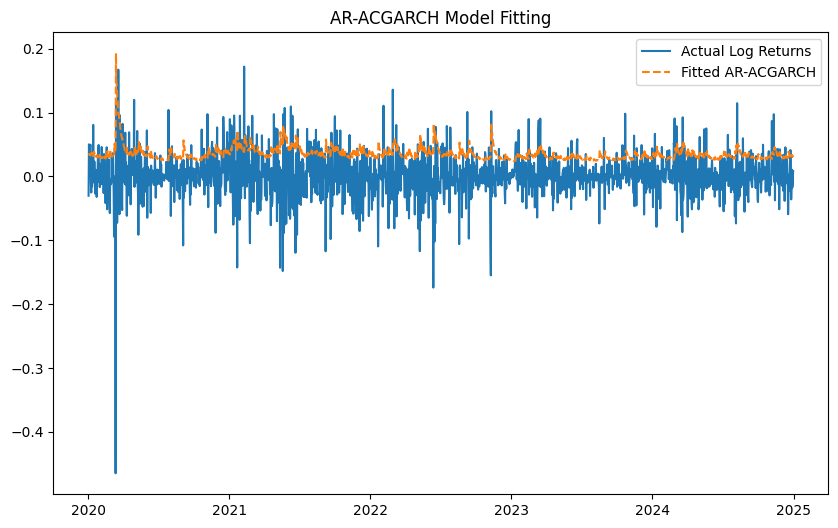

In [140]:
# Ignore the ValueWarning from statsmodels AutoReg
import warnings
warnings.simplefilter("ignore", ValueWarning)

# Assuming 'btc' is the DataFrame you provided with 'Log_Return' column
# We fit the AR part first

# Fit AutoReg model for AR part
ar_model = AutoReg(btc['Log_Return'].dropna(), lags=1)  # you can change the number of lags if needed
ar_result = ar_model.fit()

# Get the residuals (errors) from the AR model
btc['AR_Residuals'] = ar_result.resid

# Now, fit a GARCH model to the residuals
garch_model = arch_model(btc['AR_Residuals'].dropna(), vol='Garch', p=1, q=1)  # p and q can be adjusted
garch_result = garch_model.fit()

# Print summary of the GARCH model
print(garch_result.summary())

# Now, to get the AR-ACGARCH model (which is essentially the combination of AR + GARCH), you would:
btc['AR_GARCH_Fitted'] = ar_result.fittedvalues + garch_result.conditional_volatility

# Plot the actual and fitted returns
plt.figure(figsize=(10, 6))
plt.plot(btc['Date'],btc['Log_Return'], label='Actual Log Returns')
plt.plot(btc['Date'],btc['AR_GARCH_Fitted'], label='Fitted AR-ACGARCH', linestyle='--')
plt.legend()
plt.title('AR-ACGARCH Model Fitting')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'btc_data.csv'